In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# from pandasql import sqldf
import pandas as pd
from sklearn import datasets

from google.colab import drive
drive.mount('/content/gdrive')

import pandas as pd
df = pd.read_csv("gdrive/My Drive/dataset/Amazon_fine_food_review.csv")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pandas as pd

filtered_data = df[df['Score'] != 3].head(5000)



In [ ]:
filtered_data

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
5422,5423,B00622CYVS,A17ASMX6QMO6XY,E. Harvill,0,1,2,1277424000,Not so tasty...,"My baby didn't seem into these dinners, so I t..."
5423,5424,B00622CYVS,A32DHN8U74GCAR,"Granola Girl ""michele j.""",0,1,4,1240790400,Food Delivery,This is great! Organic baby food options - de...
5424,5425,B00622CYVS,A2YHXAZLCLDT8D,"Mark Smith ""Food lover""",0,1,5,1236988800,Dinner time is Earths Best TIme !!,My little guy loves to try new foods..so this ...
5425,5426,B00622CYVS,A2NYT3UXUTBY23,C&GHoll,1,3,2,1249603200,Wrong item shipped,We ordered the Earth's best 2nd dinner variety...


In [ ]:
# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition)
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [ ]:
import pandas as pd

# Assuming you have the 'filtered_df' DataFrame from previous filtering
# Create a DataFrame that includes rows where 'Score' is not equal to 3 and has more than one occurrence per 'UserId'
result = filtered_data.groupby('UserId').filter(lambda group: len(group) > 1)

# Group the filtered DataFrame and count occurrences
result = result.groupby(['UserId', 'ProductId', 'ProfileName', 'Time', 'Score', 'Text']).size().reset_index(name='Count')

# Display the result
result


,UserId,ProductId,ProfileName,Time,Score,Text,Count
0,A132ETQPMHQ585,B00139TT72,"Donna's Reviews ""I Love Shopping on Amazon!""",1324166400,0,Good but not my favorite.........Newman's Own ...,1
1,A132ETQPMHQ585,B001RVFDOO,"Donna's Reviews ""I Love Shopping on Amazon!""",1309737600,0,OK...but would never buy them again my husband...,1
2,A13E0ARAXI6KJW,B000F9Z1WI,Ed Uyeshima,1156464000,1,I hate to admit I miss the lard. I was the one...,1
3,A13E0ARAXI6KJW,B000F9Z1WI,Ed Uyeshima,1204502400,1,I hate to admit I miss the lard. I was the one...,1
4,A13T0V3LHOTHDL,B0045IK1CK,"E. Treants ""tree""",1317427200,1,This is a much better Hot Chocolate than some ...,1
...,...,...,...,...,...,...,...
304,AY1EF0GOH80EK,B000G6RYNE,Natasha Stryker,1327708800,1,Someone brought these to a party we had last m...,1
305,AY1EF0GOH80EK,B001EPPCNK,Natasha Stryker,1349395200,1,So I got this and tasted it strait out of the ...,1
306,AZV26LP92E6WU,B000G33MVK,"M. Hammond ""ColemanFlGuy""",1262217600,1,It is great! I like it alot. Great price too. ...,1
307,AZV26LP92E6WU,B0045TDE4Q,"M. Hammond ""ColemanFlGuy""",1347148800,1,i followed the easy instructions and these tur...,1


In [ ]:
print(result.shape)
result.head()

(309, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,Count
0,A132ETQPMHQ585,B00139TT72,"Donna's Reviews ""I Love Shopping on Amazon!""",1324166400,0,Good but not my favorite.........Newman's Own ...,1
1,A132ETQPMHQ585,B001RVFDOO,"Donna's Reviews ""I Love Shopping on Amazon!""",1309737600,0,OK...but would never buy them again my husband...,1
2,A13E0ARAXI6KJW,B000F9Z1WI,Ed Uyeshima,1156464000,1,I hate to admit I miss the lard. I was the one...,1
3,A13E0ARAXI6KJW,B000F9Z1WI,Ed Uyeshima,1204502400,1,I hate to admit I miss the lard. I was the one...,1
4,A13T0V3LHOTHDL,B0045IK1CK,"E. Treants ""tree""",1317427200,1,This is a much better Hot Chocolate than some ...,1


In [ ]:
# result[result['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,Count


In [ ]:
# display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [ ]:
result = result.drop_duplicates(subset=['UserId'])
result

,UserId,ProductId,ProfileName,Time,Score,Text,Count
0,A132ETQPMHQ585,B00139TT72,"Donna's Reviews ""I Love Shopping on Amazon!""",1324166400,0,Good but not my favorite.........Newman's Own ...,1
2,A13E0ARAXI6KJW,B000F9Z1WI,Ed Uyeshima,1156464000,1,I hate to admit I miss the lard. I was the one...,1
4,A13T0V3LHOTHDL,B0045IK1CK,"E. Treants ""tree""",1317427200,1,This is a much better Hot Chocolate than some ...,1
6,A14I86SK59DIX,B000ER1DIM,ginabi,1327190400,1,Bought these for my grandbabies and they love ...,1
8,A15USNEAJUXOSH,B000G6RYNE,L. Schrank,1326067200,1,I enjoy these chips. I got these instead of my...,1
...,...,...,...,...,...,...,...
295,AVCA516CFZ9HF,B004K2IHUO,S. Fowler,1335139200,1,The crust on these tarts are perfect. My husb...,1
297,AXO4PQU0XG3TG,B000CS9ZTC,Dwight,1173657600,0,I wait for this cereal to go on sale before I ...,1
299,AY12DBB0U420B,B000X2CWTM,Gary Peterson,1263340800,1,I've always liked licorice candy and the best ...,1
304,AY1EF0GOH80EK,B000G6RYNE,Natasha Stryker,1327708800,1,Someone brought these to a party we had last m...,1


In [ ]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [ ]:
sorted_data.shape

(5000, 10)

In [ ]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [ ]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

In [ ]:
final

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
2773,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,1,1282953600,thirty bucks?,Why is this $[...] when the same product is av...
2774,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,1,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...
1243,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...
1244,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...
3203,3204,B000084DVR,A1UGDJP1ZJWVPF,"T. Moore ""thoughtful reader""",1,1,1,1177977600,Good stuff!,I'm glad my 45lb cocker/standard poodle puppy ...
...,...,...,...,...,...,...,...,...,...,...
764,765,B009HINRX8,A1OEL4UZT3KKI4,"coffee drinker in PA ""coffee drinker in PA""",0,0,1,1344988800,great coffee - terrible price,"This is one of the best choices, in my opinion..."
763,764,B009HINRX8,ADDBLG0CFY9AI,S.A.D.,1,1,1,1326758400,Best of the Tassimo's,We've tried many Tassimo flavors. This is by ...
762,763,B009HINRX8,A3N9477PUE6WMR,patc477,4,4,1,1323302400,Good Tasting cup o' joe,This is a bold blend that has a great taste. T...
767,768,B009HINRX8,A2CAZG1CQ8BQI5,Patricia J. Nohalty,0,0,1,1337212800,Kona for Tassimo,Of all the coffee's available for Tassimo this...


Observation:- It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [ ]:
final = final[final['HelpfulnessNumerator'] <= final['HelpfulnessDenominator']]


In [ ]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

Preprocessing:
Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

Begin by removing the html tags
Remove any punctuations or limited set of special characters like , or . or # etc.
Check if the word is made up of english letters and is not alpha-numeric
Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
Convert the word to lowercase
Remove Stopwords
Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)
After which we collect the words used to describe positive and negative reviews

In [ ]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [ ]:
# Function to remove URLs
def remove_urls(text):
    return re.sub(r'http\S+|www.\S+', '', text)

# Apply the function to the 'text' column
final['Text'] = final['Text'].apply(remove_urls)


In [ ]:
# function to use beautiful soup
# This code will remove HTML tags and provide you with the plain text content.
import pandas as pd
from bs4 import BeautifulSoup

def parse_html(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

final['Text'] = final['Text'].apply(parse_html)


In [ ]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
final['Text'] = final['Text'].apply(decontracted)


In [ ]:
# for demonstration
print(sent_1500)
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you don't like that combination, don't order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let's also remember that tastes differ; so, I've given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I don't see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They aren't individually wrapped, which would add to the cost.  Oh yeah, cho

In [ ]:
#remove words with numbers python
def rem_num(phrase):
  sent = re.sub("\S*\d\S*", "", phrase).strip()
  return sent

final['Text'] = final['Text'].apply(rem_num)
final['Text']

2773    Why is this $[...] when the same product is av...
2774    We have used the Victor fly bait for  seasons....
1243    I just received my shipment and could hardly w...
1244    This was a really good idea and the final prod...
3203    I am glad my  cocker/standard poodle puppy lov...
                              ...                        
764     This is one of the best choices, in my opinion...
763     We have tried many Tassimo flavors.  This is b...
762     This is a bold blend that has a great taste. T...
767     Of all the coffee is available for Tassimo thi...
1477    This coffee supposedly is premium, it tastes w...
Name: Text, Length: 4986, dtype: object

In [ ]:
#remove spacial character
def rem_char(phrase):
  sent = re.sub('[^A-Za-z0-9]+', ' ', phrase).strip()
  return sent

final['Text'] = final['Text'].apply(rem_char)
final['Text']

2773    Why is this when the same product is available...
2774    We have used the Victor fly bait for seasons C...
1243    I just received my shipment and could hardly w...
1244    This was a really good idea and the final prod...
3203    I am glad my cocker standard poodle puppy love...
                              ...                        
764     This is one of the best choices in my opinion ...
763     We have tried many Tassimo flavors This is by ...
762     This is a bold blend that has a great taste Th...
767     Of all the coffee is available for Tassimo thi...
1477    This coffee supposedly is premium it tastes wa...
Name: Text, Length: 4986, dtype: object

In [ ]:
# Download the stopwords if you haven't already
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Combining all the things
from nltk.corpus import stopwords
# Download the stopwords if you haven't already
nltk.download('stopwords')
# Tokenize the sentence

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    words = sentance.split()
    # Filter out stopwords
    filtered_words = [word.lower() for word in words if word.lower() not in stopwords.words('english')]
    # Rejoin the filtered words into a sentence
    filtered_sentence = ' '.join(filtered_words)
    final['Text'] = filtered_sentence
    preprocessed_reviews.append(filtered_sentence.strip())

100%|██████████| 4986/4986 [00:49<00:00, 99.82it/s] 


In [ ]:
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords

# Assuming 'final' is your DataFrame
final['Preprocessed_Reviews'] = final['Text'].apply(lambda sentance:
    ' '.join([word.lower() for word in re.sub(r'[^A-Za-z]+', ' ', decontracted(BeautifulSoup(re.sub(r"http\S+", "", sentance), 'lxml').get_text())).split() if word.lower() not in stopwords.words('english')]).strip()
)


In [ ]:
preprocessed_reviews[1500]

'wow far two two star reviews one obviously idea ordering wants crispy cookies hey sorry reviews nobody good beyond reminding us look ordering chocolate oatmeal cookies like combination order type cookie find combo quite nice really oatmeal sort calms rich chocolate flavor gives cookie sort coconut type consistency let also remember tastes differ given opinion soft chewy cookies advertised crispy cookies blurb would say crispy rather chewy happen like raw cookie dough however see taste like raw cookie dough soft however confusion yes stick together soft cookies tend individually wrapped would add cost oh yeah chocolate chip cookies tend somewhat sweet want something hard crisp suggest nabiso ginger snaps want cookie soft chewy tastes like combination chocolate oatmeal give try place second order'

Proprocessing Review Summary

In [ ]:
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    words = sentance.split()
    # Filter out stopwords
    filtered_words = [word.lower() for word in words if word.lower() not in stopwords.words('english')]
    # Rejoin the filtered words into a sentence
    filtered_sentence = ' '.join(filtered_words)
    preprocessed_summary.append(filtered_sentence.strip())


100%|██████████| 4986/4986 [00:05<00:00, 985.70it/s]


In [ ]:
preprocessed_summary[100]

'minced ground beef'

Bag of Words

In [ ]:
#BoW in 'Reviews"
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names_out()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa' 'aahhhs' 'aback' 'abandon' 'abates' 'abbott' 'abby' 'abdominal'
 'abiding' 'ability']
the type of count vectorizer  <class 'scipy.sparse._csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 13048)
the number of unique words  13048


In [ ]:
#BoW in 'Summary"
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_summary)
print("some feature names ", count_vect.get_feature_names_out()[:10])
print('='*50)

final_counts_summary = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['able' 'absolute' 'absolutely' 'absotively' 'acceptable' 'accidents'
 'acid' 'acidic' 'acne' 'acquired']
the type of count vectorizer  <class 'scipy.sparse._csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 13048)
the number of unique words  13048


In [ ]:
# get the list of vocabulary
vocabulary_list_bow = count_vect.get_feature_names_out()


In [ ]:
count_vect.get_feature_names_out()

array(['able', 'absolute', 'absolutely', ..., 'zero', 'zesty', 'zippy'],
      dtype=object)

Bi-grams and N-grams

In [ ]:
#bi-gram, tri-gram and n-gram

count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse._csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 2991)
the number of unique words including both unigrams and bigrams  2991


tf-idf

In [ ]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names_out()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability' 'able' 'able find' 'able get' 'absolute' 'absolutely'
 'absolutely delicious' 'absolutely love' 'according' 'acid']
the type of count vectorizer  <class 'scipy.sparse._csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 2991)
the number of unique words including both unigrams and bigrams  2991


word2vec

In [ ]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())


In [ ]:

# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need
from gensim.models import KeyedVectors

is_your_ram_gt_16g=True
want_to_use_google_w2v = True
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    # w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    w2v_model = Word2Vec(list_of_sentance, min_count=5, vector_size=50, workers=4)
    print("1")
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))

elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('gdrive/My Drive/dataset/GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print("2")
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

1
[('excellent', 0.9879277348518372), ('especially', 0.9869354367256165), ('alternative', 0.9857172966003418), ('licorice', 0.9848777055740356), ('healthier', 0.9847351908683777), ('regular', 0.9841542840003967), ('popchips', 0.9840731620788574), ('amazing', 0.9840046763420105), ('terms', 0.9836547374725342), ('looking', 0.9834456443786621)]
[('opinion', 0.9977235198020935), ('varieties', 0.9972403049468994), ('yet', 0.9971864819526672), ('popcorn', 0.9970571398735046), ('goes', 0.9970457553863525), ('unlike', 0.9969488382339478), ('amazing', 0.9968163371086121), ('enjoyed', 0.9968137741088867), ('gourmet', 0.9967362284660339), ('turned', 0.9967057704925537)]


In [ ]:
# pre-trained word2vec
from gensim.models import KeyedVectors

# Load the pre-trained Word2Vec model
word2vec_model = KeyedVectors.load_word2vec_format('gdrive/My Drive/dataset/GoogleNews-vectors-negative300.bin', binary=True)


# Apply the function to your DataFrame's text column


In [ ]:
final_short = final.head(1000)

In [ ]:
def get_word_vectors(text):
    # Tokenize and preprocess the text (replace with your preprocessing logic)
    # words = text.split()  # Basic tokenization by splitting on spaces
    # words = [word.lower() for word in words]  # Lowercase
    # Remove words not in the model's vocabulary
    words = [word for word in vocabulary_list_bow if word in word2vec_model.key_to_index]
    # Get the word vectors for each word
    word_vectors = [word2vec_model[word] for word in words]
    return word_vectors
final_short['word_vectors'] = final_short['Text'].apply(get_word_vectors)


In [ ]:
w2v_words = [word for word in word2vec_model.key_to_index.keys() if word.isalpha()]


In [ ]:
final_short['word_vectors'].shape

(1000,)

In [ ]:
type(w2v_model.wv)

gensim.models.keyedvectors.KeyedVectors

In [ ]:
sent_vectors = []  # The avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance):  # for each review/sentence
    sent_vec = np.zeros(50)  # Assuming word vectors are of length 50

    # Initialize a counter for the number of words with valid vectors in the sentence/review
    cnt_words = 0

    for word in sent:  # for each word in a review/sentence
        if word in w2v_words:  # Check if the word exists in the Word2Vec model's vocabulary
            vec = w2v_model.wv[word]  # Get the Word2Vec vector for the word
            sent_vec += vec  # Add the vector to the sentence vector
            cnt_words += 1  # Increment the word count

    if cnt_words != 0:
        # Calculate the average vector for the sentence
        sent_vec /= cnt_words

    sent_vectors.append(sent_vec)


In [ ]:
vocabulary_list = w2v_model.wv.index_to_key


In [ ]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in vocabulary_list:
            # print(word)
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1

    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

tf-idf weighted word2vec

In [ ]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names_out(), list(model.idf_)))

In [ ]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names_out() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

Bag of Words and SVM

Linear SVM with BOW

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Preprocessing (tokenization, lowercasing, etc.) may be required, depending on your data.

# Split the dataset into a training set and a test set (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(final['Preprocessed_Reviews'], final['Score'], test_size=0.2, random_state=42)

# Create a Bag of Words representation
count_vectorizer = CountVectorizer()
X_train_bow = count_vectorizer.fit_transform(X_train)
X_test_bow = count_vectorizer.transform(X_test)

# Train an SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_bow, y_train)

# Make predictions
y_pred = svm_model.predict(X_test_bow)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(report)


Accuracy: 0.8857715430861723
              precision    recall  f1-score   support

           0       0.63      0.67      0.65       156
           1       0.94      0.93      0.93       842

    accuracy                           0.89       998
   macro avg       0.78      0.80      0.79       998
weighted avg       0.89      0.89      0.89       998



Linear SVM with tf-idf

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer  # Import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Split the dataset into a training set and a test set (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(final['Preprocessed_Reviews'], final['Score'], test_size=0.2, random_state=42)

# Create a TF-IDF representation
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Train an SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = svm_model.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(report)


Accuracy: 0.9078156312625251
              precision    recall  f1-score   support

           0       0.86      0.49      0.62       156
           1       0.91      0.99      0.95       842

    accuracy                           0.91       998
   macro avg       0.89      0.74      0.79       998
weighted avg       0.90      0.91      0.90       998



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Split the dataset into a training set and a test set (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(final['Preprocessed_Reviews'], final['Score'], test_size=0.2, random_state=42)

# Create a TF-IDF representation with min_df and max_features
tfidf_vectorizer = TfidfVectorizer(min_df=10, max_features=500)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Train an SVM model with 'rbf' kernel
svm_model = SVC(kernel='rbf')
svm_model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = svm_model.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Generate the AUC score
y_pred_prob = svm_model.decision_function(X_test_tfidf)
auc_score = roc_auc_score(y_test, y_pred_prob)

print(f"Accuracy: {accuracy}")
print(report)
print(f"AUC Score: {auc_score}")


Accuracy: 0.875751503006012
              precision    recall  f1-score   support

           0       0.97      0.21      0.35       156
           1       0.87      1.00      0.93       842

    accuracy                           0.88       998
   macro avg       0.92      0.61      0.64       998
weighted avg       0.89      0.88      0.84       998

AUC Score: 0.8882468481637128


Parameter tuning with grid search

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score


# Split the dataset into a training set and a test set (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(final['Preprocessed_Reviews'], final['Score'], test_size=0.2, random_state=42)

# Create a TF-IDF representation with min_df and max_features
tfidf_vectorizer = TfidfVectorizer(min_df=10, max_features=500)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Define a parameter grid for hyperparameter tuning
param_grid = {
    'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000, 10000],
    'kernel': ['rbf']
}

# Create an SVM classifier
svm_model = SVC()

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, scoring='roc_auc', cv=5)
grid_search.fit(X_train_tfidf, y_train)

# Get the best hyperparameters
best_C = grid_search.best_params_['C']

# Train an SVM model with the best 'C' hyperparameter
best_svm_model = SVC(C=best_C, kernel='rbf')
best_svm_model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = best_svm_model.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Generate the AUC score
y_pred_prob = best_svm_model.decision_function(X_test_tfidf)
auc_score = roc_auc_score(y_test, y_pred_prob)

print(f"Best C: {best_C}")
print(f"Accuracy: {accuracy}")
print(report)
print(f"AUC Score: {auc_score}")


Best C: 10
Accuracy: 0.8947895791583166
              precision    recall  f1-score   support

           0       0.79      0.44      0.57       156
           1       0.90      0.98      0.94       842

    accuracy                           0.89       998
   macro avg       0.85      0.71      0.75       998
weighted avg       0.89      0.89      0.88       998

AUC Score: 0.8868917108228271


Selecting 10 best features for positive and negative class

In [ ]:
# Get the decision function scores for each instance
decision_function_scores = best_svm_model.decision_function(X_test_tfidf)

# Get the indices of the top positive and negative instances
top_positive_indices = decision_function_scores.argsort()[-10:][::-1]  # Top 10 positive instances
top_negative_indices = decision_function_scores.argsort()[:10]  # Top 10 negative instances

# Get the feature names from the TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Print the top features for the positive class
print("Top 10 features for the positive class:")
for idx in top_positive_indices:
    features = X_test_tfidf[idx].indices
    feature_weights = X_test_tfidf[idx].data
    top_features = [feature_names[feature] for _, feature in sorted(zip(feature_weights, features), reverse=True)[:10]]
    print(f"Instance {idx}: {', '.join(top_features)}")

# Print the top features for the negative class
print("\nTop 10 features for the negative class:")
for idx in top_negative_indices:
    features = X_test_tfidf[idx].indices
    feature_weights = X_test_tfidf[idx].data
    top_features = [feature_names[feature] for _, feature in sorted(zip(feature_weights, features), reverse=True)[:10]]
    print(f"Instance {idx}: {', '.join(top_features)}")


Top 10 features for the positive class:
Instance 148: needed, pop, alternative, great, especially, deal, fat, variety, low, highly
Instance 970: love, sodium, serving, cheese, snacks, crunchy, must, great, plus, per
Instance 743: great, licorice, plus, kids, added, treat, around, excellent, family, tasty
Instance 458: organic, perfect, snack, makes, price, find, amazon, love
Instance 725: coffee, dinner, worth, feel, wonderful, cup, great, like, well, make
Instance 460: every, years, use, find, sodium, flavor, along, cheese, recently, market
Instance 747: always, excellent, good
Instance 507: especially, excellent, ever, tea, best, one, great
Instance 696: snack, calorie, husband, year, old, eating, day, well, love, great
Instance 755: great, best, formula, feeding, seems, variety, around, new, organic, foods

Top 10 features for the negative class:
Instance 37: plain, disappointed, item, tasted, flavor, like
Instance 604: think, bars, thin, cookies, nothing, come, money, things, milk,

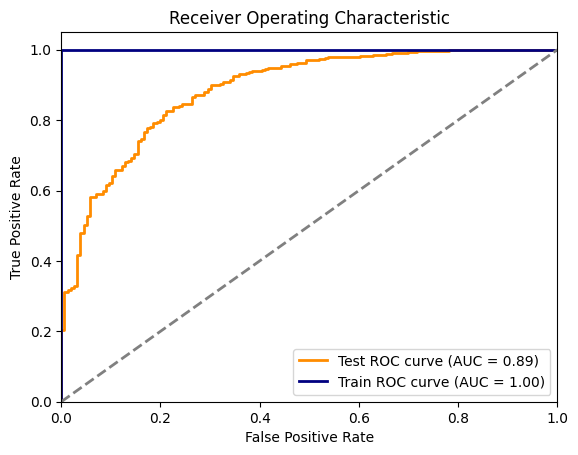

Best C: 10
Accuracy: 0.8947895791583166
              precision    recall  f1-score   support

           0       0.79      0.44      0.57       156
           1       0.90      0.98      0.94       842

    accuracy                           0.89       998
   macro avg       0.85      0.71      0.75       998
weighted avg       0.89      0.89      0.88       998

AUC Score (Test): 0.8868917108228271
AUC Score (Train): 1.0


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Generate the AUC score for the test data
y_pred_prob_test = best_svm_model.decision_function(X_test_tfidf)
auc_score_test = roc_auc_score(y_test, y_pred_prob_test)

# Generate the AUC score for the train data
y_pred_prob_train = best_svm_model.decision_function(X_train_tfidf)
auc_score_train = roc_auc_score(y_train, y_pred_prob_train)

# Compute ROC curves
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_prob_test)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_prob_train)

# Plot ROC curves
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'Test ROC curve (AUC = {auc_score_test:.2f})')
plt.plot(fpr_train, tpr_train, color='navy', lw=2, label=f'Train ROC curve (AUC = {auc_score_train:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

print(f"Best C: {best_C}")
print(f"Accuracy: {accuracy}")
print(report)
print(f"AUC Score (Test): {auc_score_test}")
print(f"AUC Score (Train): {auc_score_train}")
